# Deep Learning with Python

# 3. Sequential Model

## 3.1. Simple Convolution Neural Network
## 3.1.1 Construction of CNN

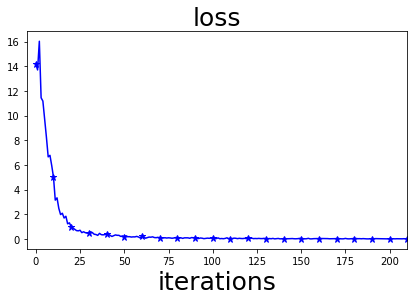

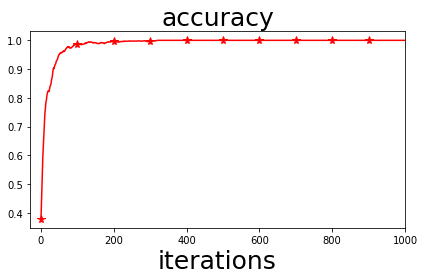

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from deepL_module.datasets.mnist import load_mnist
from deepL_module.nn.sequential import Sequential
from deepL_module.nn.optimizers import *
from deepL_module.base import *
from deepL_module.nn.layers import *
from deepL_module.nn import *
%matplotlib inline

max_iter = 1000


'''#0 loading data '''
(X_train, train_t), (X_test, test_t) = load_mnist(normalize=True, flatten=False)
X_train, train_t = X_train[:5000], train_t[:5000]
train_t = to_categorical(train_t)


'''#1 config for NN '''
model = Sequential()
model.add(Conv2D(16,(3,3),input_shape=(1,28,28)))
model.add(Activation('relu'))
model.add(Maxpooling(pool_h=2, pool_w=2, stride=2))
model.add(Conv2D(16,(3,3)))
model.add(Activation('relu'))
model.add(Maxpooling(pool_h=2, pool_w=2, stride=2))
model.add(Dense(100, activation='relu'))
model.add(Dense(10))


# optimizer
routine = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=routine)


'''#2 learning '''
hist = model.fit(X_train, train_t,
                 batch_size=256,
                 n_iter=max_iter,
                 history=True)



'''#3 drawing loss & accuracy data '''
# ----- loss data -----
fig=plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(121)
x = np.arange(max_iter)
ax1.plot(x, hist['loss'], color='blue',marker="*", markersize=7, markevery=10,label='loss')
ax1.set_xlabel("iterations",fontsize=25)
ax1.set_title("loss",fontsize=25)
ax1.set_xlim([-5,210])
plt.show()

# --- accuracy data ---
fig.add_subplot(122)
plt.plot(x, smooth_filt(hist['acc']),
        color = 'red',
        marker = "*",
        markersize = 8,
        markevery = 100,
        label='accuracy')
plt.xlabel("iterations",fontsize=25)
plt.title("accuracy",fontsize=25)
plt.xlim([-30,1000])
plt.tight_layout()
plt.show()

model.save(name='simple_CNN')

## 3.1.2 The recognition of hand-written number

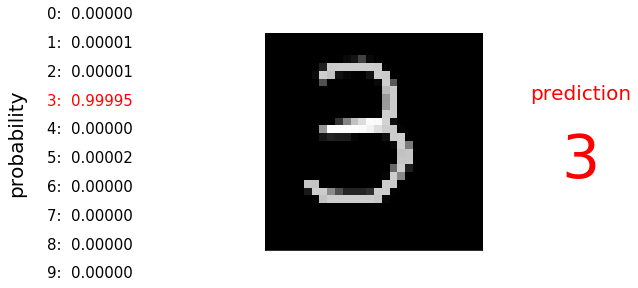

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from deepL_module.datasets.mnist import load_mnist
from deepL_module.base import *
from skimage import color
from skimage.util import invert
from skimage.transform import rescale, resize, downscale_local_mean


''' #1 load model data '''
path_r = './../prml/deepL_module/datasets/model_data/simple_CNN.pkl'
model = load_model(path_r)


''' #2 load image data '''
path_img = './../test_keras/image_recognition/image_data/my_data/_image.png'
read_img = plt.imread(path_img)
gray_img = color.rgb2gray(read_img)

# resize image
width, height = gray_img.shape
cent_w, cent_h = width // 2, height // 2
cut_size = 300 # trimming size [pixel]
margin = cut_size // 2
image = gray_img[cent_h - margin : cent_h + margin,
                 cent_w - margin : cent_w + margin]


''' #3 processing image '''
image_resized = rescale(image, 1. / (cut_size / 28.),
                        anti_aliasing = True,
                        multichannel = False,
                        anti_aliasing_sigma = 1.5)
data = invert(image_resized)



''' #4 prediction data'''
Xt = data.reshape(1,1,28,28)
prob = model.predict(Xt)
pred = np.argmax(prob)


''' #5 showing image '''
fig = plt.figure(figsize=(11,4))
ax = fig.add_subplot(111)
ax.imshow(data, cmap='gray')
plt.tick_params(labelbottom = False,
                labelleft = False,
                bottom = False,
                left = False)


# --- probability ---
fig.text(0.05,0.5,"probability",rotation=90, size=20, verticalalignment='center')
c_list = ['k'] * 10
c_list[pred] = 'r'
for n,p in enumerate(prob.ravel()):
    text = '{}:  {:.5f}'.format(n, float(np.round(p,8)))
    fig.text(0.1, 0.93-0.1*n, text, color=c_list[n], size=15)


# --- prediction ---
pos = ax.get_position()
pos_y = 0.5 * (pos.y1 - pos.y0)
fig.text(0.75, pos_y, str(pred), fontsize=60, color='r')
fig.text(0.71,0.65, "prediction",
        fontsize=20,
        transform=fig.transFigure,
        color='r')
plt.show()

## 3.2. The effect of Batch normalization

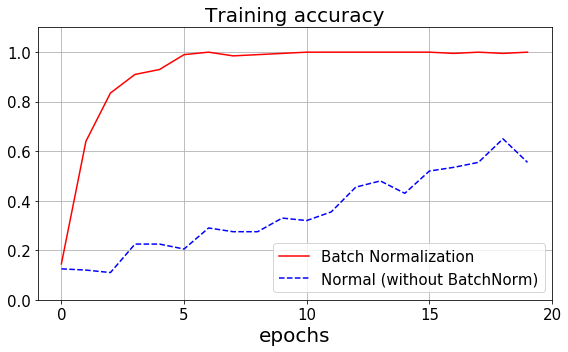

In [3]:
import matplotlib.pyplot as plt
from deepL_module.datasets.mnist import load_mnist
from deepL_module.nn.sequential import Sequential
from deepL_module.nn.multi_layer_nn import *
from deepL_module.nn.optimizers import *
from deepL_module.base import *
from deepL_module.nn.layers import *
import copy

# === loading data ===
(X_train, train_t), (X_test, test_t) = load_mnist(normalize=True)

# data reduction
X_train = X_train[:1000]
train_t = train_t[:1000]
train_t = to_categorical(train_t)

# setting parameters
max_epochs = 20
train_size = X_train.shape[0]
batch_size = 200
learning_rate = 0.01
scale = 0.005
iter_per_epoch = max(train_size / batch_size, 1)
max_iter = int(max_epochs * iter_per_epoch)

# constructing model
model = Sequential(w_std=scale)
model.add(Dense(50, input_dim=784, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(70, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10))


bn_model = Sequential(w_std=scale)

bn_model.add(Dense(50, input_dim=784))
bn_model.add(Batch_norm_Layer())
bn_model.add(Activation('relu'))

bn_model.add(Dense(100))
bn_model.add(Batch_norm_Layer())
bn_model.add(Activation('relu'))

bn_model.add(Dense(70))
bn_model.add(Batch_norm_Layer())
bn_model.add(Activation('relu'))

bn_model.add(Dense(100))
bn_model.add(Batch_norm_Layer())
bn_model.add(Activation('relu'))

bn_model.add(Dense(10))


model_dict = {'batch_norm':bn_model, 'normal':model}
train_acc = {}


'''---- learning ----'''
for name, network_ in model_dict.items():
    optim = Adam(lr=learning_rate)
    network_.compile(loss='categorical_crossentropy', optimizer=optim)
    hist = network_.fit(X_train, train_t,
                        n_iter=max_iter,
                        batch_size=batch_size,
                        history=True)
    train_acc[name] = np.asarray(hist['acc'])


# drawing graph
x = np.arange(max_epochs)
idx = np.arange(0, max_iter, iter_per_epoch)
idx = list(map(int,idx))

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

ax.plot(x, train_acc['batch_norm'][idx],
        label='Batch Normalization', markevery=2, color='r')
ax.plot(x, train_acc['normal'][idx], linestyle = "--",
        label='Normal (without BatchNorm)', markevery=2, color='blue')

plt.legend(fontsize=15)
plt.title('Training accuracy', fontsize=20)
plt.xlabel('epochs',fontsize=20)
plt.xticks(np.arange(0,max_epochs+1,5),fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,1.1)
plt.tight_layout()
plt.grid()
plt.show()